In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


# LSTM com retroaliemntacao da saida da rede

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import optuna

# -------------------------------
# Data Loading and Preparation
# -------------------------------
# Load data
input1 = np.load("input1.npy")
output = np.load("output.npy")

input1 = input1[::3]
output = output[:, ::3]

# Prepare data for LSTM
X = np.hstack((output.T, input1.reshape(-1, 1)))  # Concatenate output and input
Y = output.T[1:, :]  # Shifted outputs

# Reshape data for LSTM: (n_samples, timesteps, n_features)
X = X.reshape((X.shape[0], 1, X.shape[1]))
Y = Y.reshape((Y.shape[0], Y.shape[1]))

# Split data into training and validation sets
train_size = 500
val_size = 300
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = (
    X[train_size : train_size + val_size],
    Y[train_size : train_size + val_size],
)


# -------------------------------
# Optuna Optimization
# -------------------------------
def objective(trial):
    # Suggest hyperparameters
    lstm_units1 = trial.suggest_int("lstm_units1", 32, 128, step=16)
    lstm_units2 = trial.suggest_int("lstm_units2", 32, 128, step=16)
    lstm_units3 = trial.suggest_int("lstm_units3", 16, 64, step=16)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 50  # Use a lower number of epochs for faster tuning

    # Build the LSTM model with trial-suggested hyperparameters
    model = Sequential()
    model.add(
        LSTM(
            lstm_units1, activation="tanh", return_sequences=True, input_shape=(None, 3)
        )
    )
    model.add(LSTM(lstm_units2, activation="tanh", return_sequences=True))
    model.add(LSTM(lstm_units3, activation="tanh", return_sequences=False))
    model.add(Dense(2))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse")

    # Early stopping to avoid overfitting during tuning
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )

    model.fit(
        X_train,
        Y_train,
        shuffle=False,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        callbacks=[early_stop],
        verbose=0,
    )

    # Evaluate the model on the validation set
    val_loss = model.evaluate(X_val, Y_val, verbose=0)
    return val_loss


# Create and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Display best hyperparameters
print("Best trial:")
trial = study.best_trial
print("Validation Loss: ", trial.value)
print("Best Hyperparameters:")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

# -------------------------------
# Final Model Training
# -------------------------------
# Use the best hyperparameters from Optuna to rebuild the final model
best_params = study.best_trial.params
model = Sequential()
model.add(
    LSTM(
        best_params["lstm_units1"],
        activation="tanh",
        return_sequences=True,
        input_shape=(None, 3),
    )
)
model.add(LSTM(best_params["lstm_units2"], activation="tanh", return_sequences=True))
model.add(LSTM(best_params["lstm_units3"], activation="tanh", return_sequences=False))
model.add(Dense(2))
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params["learning_rate"])
model.compile(optimizer=optimizer, loss="mse")

# Retrain with more data and prepare test set
train_size_retrain = 800
test_size = 5000
X_train_retrain, Y_train_retrain = X[:train_size_retrain], Y[:train_size_retrain]
X_test, Y_test = (
    X[train_size_retrain : train_size_retrain + test_size],
    Y[train_size_retrain : train_size_retrain + test_size],
)

model.fit(
    X_train_retrain,
    Y_train_retrain,
    epochs=1000,
    batch_size=best_params["batch_size"],
    verbose=1,
)

# -------------------------------
# Evaluation and Feedback Prediction
# -------------------------------
# Validation predictions
val_predictions = model.predict(X_val)

plt.figure()
plt.plot(Y_val[:, 0], label="True x")
plt.plot(val_predictions[:, 0], label="Predicted x")
plt.legend()
plt.title("Validation x")
plt.show()

plt.figure()
plt.plot(Y_val[:, 1], label="True v")
plt.plot(val_predictions[:, 1], label="Predicted v")
plt.legend()
plt.title("Validation v")
plt.show()


def predict_with_feedback(model, initial_state, u_seq):
    """
    model: trained model
    initial_state: initial state vector [x0, v0]
    u_seq: sequence of external input (array with shape (n_steps,))
    """
    predictions = []
    current_state = initial_state.copy()  # [x, v]

    for u in u_seq:
        # Build input vector: [previous state, current external input]
        input_vec = np.array([current_state[0], current_state[1], u])
        input_vec = input_vec.reshape(1, 1, 3)
        pred = model.predict(input_vec)
        pred = pred[0]
        predictions.append(pred)
        current_state = pred  # Update state for next prediction

    return np.array(predictions)


# Feedback prediction on test data
n_steps = X_test.shape[0]
initial_state = X_test[0, 0, :2]  # Take first [x, v] from test set
u_seq = X_test[:, 0, 2]  # External input sequence
test_predictions_LSTM = predict_with_feedback(model, initial_state, u_seq)

plt.figure()
plt.plot(Y_test[:, 0], label="True x")
plt.plot(test_predictions_LSTM[:, 0], label="Predicted x")
plt.legend()
plt.title("Test x with feedback")
plt.show()

plt.figure()
plt.plot(Y_test[:, 1], label="True v")
plt.plot(test_predictions_LSTM[:, 1], label="Predicted v")
plt.legend()
plt.title("Test v with feedback")
plt.show()


[I 2025-03-03 19:46:47,388] A new study created in memory with name: no-name-a9cb7bd5-2eab-4ccf-81f5-6022a40cc1cb


C:\Users\EricMochiutti\AppData\Local\Temp\ipykernel_27068\2654037977.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[I 2025-03-03 19:46:55,719] Trial 0 finished with value: 0.05595649033784866 and parameters: {'lstm_units1': 112, 'lstm_units2': 64, 'lstm_units3': 32, 'learning_rate': 0.0017715020507196163, 'batch_size': 64}. Best is trial 0 with value: 0.05595649033784866.
[I 2025-03-03 19:47:05,349] Trial 1 finished with value: 0.03734884411096573 and parameters: {'lstm_units1': 112, 'lstm_units2': 96, 'lstm_units3': 64, 'learning_rate': 0.000593621256578381, 'batch_size': 64}. Best is trial 1 with value: 0.03734884411096573.
[W 2025-03-03 19:47:11,926] Trial 2 failed with parameters: {'lstm_units1': 64, 'lstm_units2': 112, 'lstm_units3': 48, 'learning

KeyboardInterrupt: 

# PI-LSTM com physics loss

[I 2025-03-04 00:59:33,829] A new study created in memory with name: no-name-1c478b3d-6bb3-48b0-a1ef-d917be9eb3b5
[I 2025-03-04 01:00:15,825] Trial 0 finished with value: 0.03811712935566902 and parameters: {'lstm_units1': 32, 'lstm_units2': 64, 'lstm_units3': 48, 'learning_rate': 0.00026645145046534733, 'batch_size': 32}. Best is trial 0 with value: 0.03811712935566902.
[I 2025-03-04 01:00:38,632] Trial 1 finished with value: 0.052030812948942184 and parameters: {'lstm_units1': 112, 'lstm_units2': 32, 'lstm_units3': 64, 'learning_rate': 0.0005686790273254516, 'batch_size': 32}. Best is trial 0 with value: 0.03811712935566902.
[I 2025-03-04 01:01:11,026] Trial 2 finished with value: 0.07473814487457275 and parameters: {'lstm_units1': 32, 'lstm_units2': 32, 'lstm_units3': 16, 'learning_rate': 0.0009945340514064648, 'batch_size': 16}. Best is trial 0 with value: 0.03811712935566902.
[I 2025-03-04 01:01:39,492] Trial 3 finished with value: 0.10343525558710098 and parameters: {'lstm_units1

Melhor trial:
Val_loss: 0.002197792287915945
Melhores hiperparâmetros:
  lstm_units1: 112
  lstm_units2: 96
  lstm_units3: 48
  learning_rate: 0.00845913821709383
  batch_size: 32
Epoch 1/100
25/25 [==============================] - 6s 26ms/step - loss: 0.6581
Epoch 2/100
25/25 [==============================] - 1s 25ms/step - loss: 0.1097
Epoch 3/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0718
Epoch 4/100
25/25 [==============================] - 1s 24ms/step - loss: 0.0667
Epoch 5/100
25/25 [==============================] - 1s 25ms/step - loss: 0.0657
Epoch 6/100
25/25 [==============================] - 1s 22ms/step - loss: 0.0617
Epoch 7/100
25/25 [==============================] - 1s 27ms/step - loss: 0.0636
Epoch 8/100
25/25 [==============================] - 1s 25ms/step - loss: 0.0607
Epoch 9/100
25/25 [==============================] - 1s 27ms/step - loss: 0.0583
Epoch 10/100
25/25 [==============================] - 1s 26ms/step - loss: 0.0585
Epoch 11/

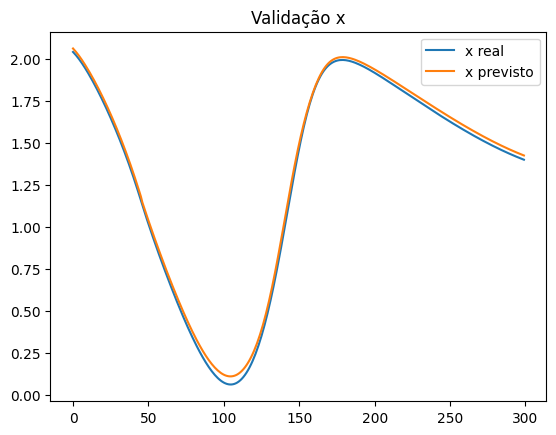

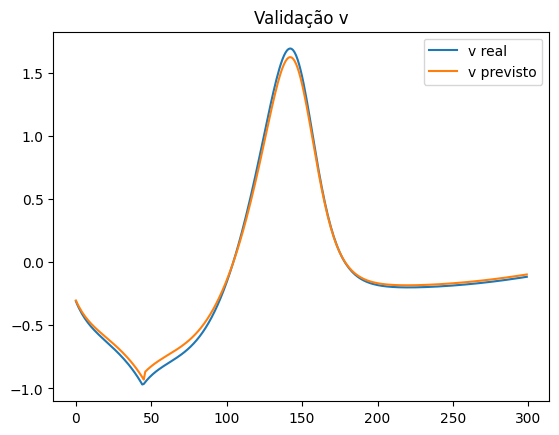

Epoch 1/100
25/25 [==============================] - 1s 27ms/step - loss: 0.0616
Epoch 2/100
25/25 [==============================] - 1s 29ms/step - loss: 0.0600
Epoch 3/100
25/25 [==============================] - 1s 27ms/step - loss: 0.0608
Epoch 4/100
25/25 [==============================] - 1s 32ms/step - loss: 0.0622
Epoch 5/100
25/25 [==============================] - 1s 29ms/step - loss: 0.0600
Epoch 6/100
25/25 [==============================] - 1s 28ms/step - loss: 0.0587
Epoch 7/100
25/25 [==============================] - 1s 30ms/step - loss: 0.0606
Epoch 8/100
25/25 [==============================] - 1s 30ms/step - loss: 0.0594
Epoch 9/100
25/25 [==============================] - 1s 33ms/step - loss: 0.0624
Epoch 10/100
25/25 [==============================] - 1s 29ms/step - loss: 0.0600
Epoch 11/100
25/25 [==============================] - 1s 31ms/step - loss: 0.0604
Epoch 12/100
25/25 [==============================] - 1s 28ms/step - loss: 0.0567
Epoch 13/100
25/25 [=====

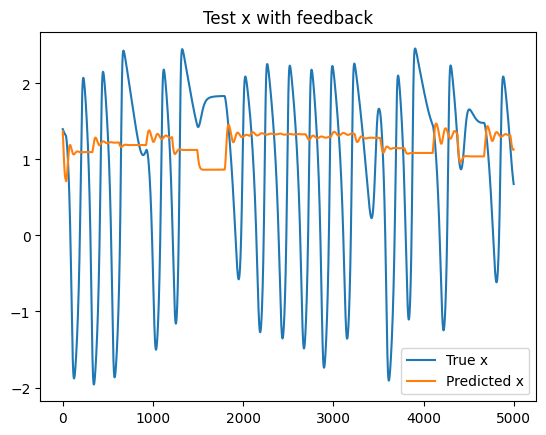

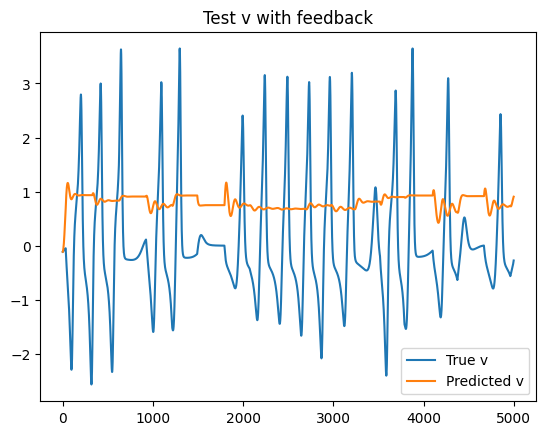

In [ ]:
# -------------------------------
# Carregar e preparar os dados
# -------------------------------
input1 = np.load("input1.npy")
output = np.load("output.npy")

input1 = input1[::3]
output = output[:, ::3]

# Parâmetro do oscilador de Van der Pol
mu = 1.0

# Preparação dos dados para a LSTM
X = np.hstack((output.T, input1.reshape(-1, 1)))  # Entrada: [x, v, u]
Y = output.T[
    1:, :
]  # Alvo: [x, v] (note que, conforme a docstring da loss, seria esperado que Y tivesse 3 colunas, com u; ajuste conforme necessário)

# Reformatar os dados para LSTM: (n_amostras, timesteps, n_features)
X = X.reshape((X.shape[0], 1, X.shape[1]))
Y = Y.reshape((Y.shape[0], Y.shape[1]))

# Divisão dos dados em treino e validação
train_size = 500
val_size = 300
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = (
    X[train_size : train_size + val_size],
    Y[train_size : train_size + val_size],
)


# -------------------------------
# Definir a função de perda física
# -------------------------------
def physics_loss(u_data):
    """
    Função de perda que recebe u_data como argumento.
    """

    def loss(y_true, y_pred):
        """
        y_true: tensor com shape (batch, 2) contendo os valores reais [x, v].
        y_pred: tensor com shape (batch, 2) contendo as predições [x, v].
        u_data: tensor com shape (batch,) contendo os valores de u.
        """
        loss_data = tf.keras.losses.MSE(y_true, y_pred)
        loss_data = tf.reduce_mean(loss_data)

        dt = 0.3
        mu = 1.0

        h1, h2 = tf.split(y_pred, num_or_size_splits=2, axis=1)

        # Importante: estamos supondo que os dados do batch estão ordenados no tempo.
        # Termo físico para a equação de x: x_{n+1} = x_n + dt * v_n
        loss_phy_x = tf.square(h1[1:] - (h1[:-1] + dt * h2[:-1]))

        # Termo físico para a equação de v:
        loss_phy_v = tf.square(
            h2[1:]
            - (
                h2[:-1]
                + dt * (mu * (1 - tf.square(h1[:-1])) * h2[:-1] - h1[:-1] + u_data[:-1])
            )
        )

        # Média dos termos físicos
        loss_phy = tf.reduce_mean(loss_phy_x + loss_phy_v)

        # Retorna a soma do erro de dados com o erro físico
        return loss_data + loss_phy * 1e-2

    return loss


# -------------------------------
# Otimização com Optuna
# -------------------------------
def objective(trial):
    # Sugerir hiperparâmetros
    lstm_units1 = trial.suggest_int("lstm_units1", 32, 128, step=16)
    lstm_units2 = trial.suggest_int("lstm_units2", 32, 128, step=16)
    lstm_units3 = trial.suggest_int("lstm_units3", 16, 64, step=16)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 50  # Usar menos épocas para acelerar a otimização

    # Construir o modelo com os hiperparâmetros sugeridos
    model = Sequential()
    model.add(
        LSTM(
            lstm_units1, activation="tanh", return_sequences=True, input_shape=(None, 3)
        )
    )
    model.add(LSTM(lstm_units2, activation="tanh", return_sequences=True))
    model.add(LSTM(lstm_units3, activation="tanh", return_sequences=False))
    model.add(Dense(2))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=physics_loss(X_train[:, 0, 2]))

    # Early stopping para evitar overfitting durante a otimização
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )

    model.fit(
        X_train,
        Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        callbacks=[early_stop],
        verbose=0,
    )

    # Avaliação no conjunto de validação
    val_loss = model.evaluate(X_val, Y_val, verbose=0)
    return val_loss


# Criar e executar o estudo
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Melhor trial:")
trial = study.best_trial
print("Val_loss:", trial.value)
print("Melhores hiperparâmetros:")
for key, value in trial.params.items():
    print(f"  {key}: {value}")

# -------------------------------
# Treinamento final com os melhores hiperparâmetros
# -------------------------------
best_params = study.best_trial.params
model = Sequential()
model.add(
    LSTM(
        best_params["lstm_units1"],
        activation="tanh",
        return_sequences=True,
        input_shape=(None, 3),
    )
)
model.add(LSTM(best_params["lstm_units2"], activation="tanh", return_sequences=True))
model.add(LSTM(best_params["lstm_units3"], activation="tanh", return_sequences=False))
model.add(Dense(2))
optimizer = tf.keras.optimizers.Adam(learning_rate=best_params["learning_rate"])
model.compile(optimizer=optimizer, loss=physics_loss(X_train[:, 0, 2]))

# Treinar o modelo final (aqui, combinamos treino e validação para um conjunto maior)
X_train_final = np.concatenate([X_train, X_val], axis=0)
Y_train_final = np.concatenate([Y_train, Y_val], axis=0)
model.fit(
    X_train_final,
    Y_train_final,
    epochs=100,
    batch_size=best_params["batch_size"],
    verbose=1,
)

# -------------------------------
# Previsões na validação e plot dos resultados
# -------------------------------
val_predictions = model.predict(X_val)

plt.figure()
plt.plot(Y_val[:, 0], label="x real")
plt.plot(val_predictions[:, 0], label="x previsto")
plt.legend()
plt.title("Validação x")
plt.show()

plt.figure()
plt.plot(Y_val[:, 1], label="v real")
plt.plot(val_predictions[:, 1], label="v previsto")
plt.legend()
plt.title("Validação v")
plt.show()

# Teste final com mais dados
train_size_retrain = 800
test_size = 5000
X_train_retrain, Y_train_retrain = X[:train_size_retrain], Y[:train_size_retrain]
X_test, Y_test = (
    X[train_size_retrain : train_size_retrain + test_size],
    Y[train_size_retrain : train_size_retrain + test_size],
)

# Re-treinar com mais dados
model.fit(
    X_train_retrain,
    Y_train_retrain,
    epochs=100,
    batch_size=best_params["batch_size"],
    verbose=1,
)


def predict_with_feedback(model, initial_state, u_seq):
    """
    model: modelo treinado
    initial_state: vetor [x0, v0] do estado inicial
    u_seq: sequência do input externo (u) para cada novo instante (array com shape (n_steps,))
    """
    predictions = []
    current_state = initial_state.copy()  # [x, v]

    for u in u_seq:
        # Monta a entrada: [estado anterior, u_atual]
        input_vec = np.array([current_state[0], current_state[1], u])
        input_vec = input_vec.reshape(1, 1, 3)  # Formato (1, 1, 3)

        pred = model.predict(input_vec)  # Predição tem shape (1, 2)
        pred = pred[0]  # vetor [x_pred, v_pred]
        predictions.append(pred)

        # Atualiza o estado para a próxima iteração
        current_state = pred

    return np.array(predictions)


# Número de passos a previr
n_steps = X_test.shape[0]

# Estado inicial: pegue o estado do primeiro exemplo do conjunto de teste
initial_state = X_test[0, 0, :2]  # [x, v]

# Sequência de input externo para os n_steps: coluna 2 de X_test
u_seq = X_test[:, 0, 2]

# Predição com feedback
test_predictions_PI_LSTM = predict_with_feedback(model, initial_state, u_seq)

# Plot dos resultados
plt.figure()
plt.plot(Y_test[:, 0], label="True x")
plt.plot(test_predictions_PI_LSTM[:, 0], label="Predicted x")
plt.legend()
plt.title("Test x with feedback")
plt.show()

plt.figure()
plt.plot(Y_test[:, 1], label="True v")
plt.plot(test_predictions_PI_LSTM[:, 1], label="Predicted v")
plt.legend()
plt.title("Test v with feedback")
plt.show()


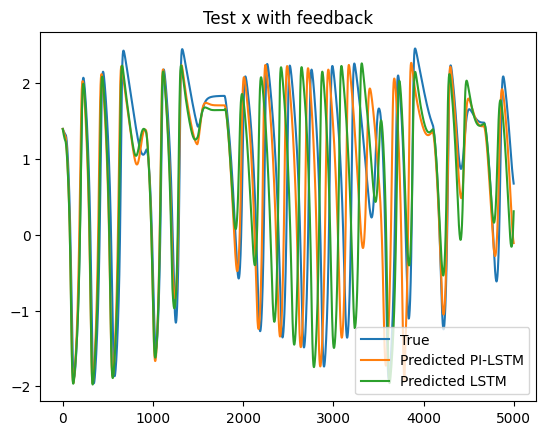

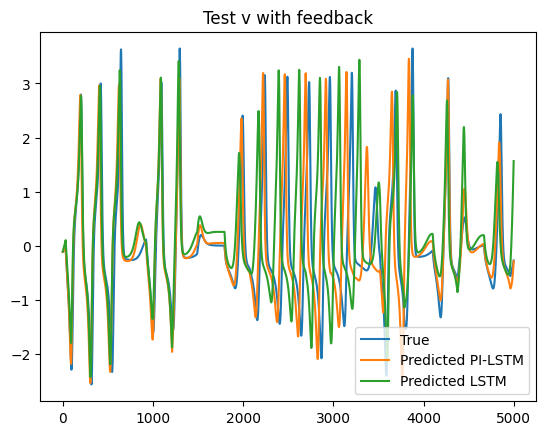

In [ ]:
# Plot dos resultados
plt.figure()
plt.plot(Y_test[:, 0], label="True")
plt.plot(test_predictions_PI_LSTM[:, 0], label="Predicted PI-LSTM")
plt.plot(test_predictions_LSTM[:, 0], label="Predicted LSTM")
plt.legend()
plt.title("Test x with feedback")
plt.show()

plt.figure()
plt.plot(Y_test[:, 1], label="True")
plt.plot(test_predictions_PI_LSTM[:, 1], label="Predicted PI-LSTM")
plt.plot(test_predictions_LSTM[:, 1], label="Predicted LSTM")
plt.legend()
plt.title("Test v with feedback")
plt.show()


In [ ]:
np.save("prediction_PI_LSTM.npy", test_predictions_PI_LSTM)

In [ ]:
np.save("prediction_LSTM.npy", test_predictions_LSTM)

In [ ]:
# Carregar dados
input1 = np.load("input1.npy")
output = np.load("output.npy")

input1 = input1[::3]
output = output[:, ::3]

# Parâmetro do oscilador de Van der Pol
mu = 1.0

# Preparação dos dados para a LSTM
X = np.hstack((output.T[:, :], input1[:].reshape(-1, 1)))  # Entrada: x, v, u
Y = output.T[1:, :]

# Reformatar os dados para LSTM
X = X.reshape((X.shape[0], 1, X.shape[1]))
Y = Y.reshape((Y.shape[0], Y.shape[1]))

# Divisão dos dados em treino e validação
train_size = 500
val_size = 300
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = (
    X[train_size : train_size + val_size],
    Y[train_size : train_size + val_size],
)


def physics_loss(u_data):
    """
    Função de perda que recebe u_data como argumento.
    """

    def loss(y_true, y_pred):
        """
        y_true: tensor com shape (batch, 2) contendo os valores reais [x, v].
        y_pred: tensor com shape (batch, 2) contendo as predições [x, v].
        u_data: tensor com shape (batch,) contendo os valores de u.
        """
        loss_data = tf.keras.losses.MSE(y_true, y_pred)
        loss_data = tf.reduce_mean(loss_data)

        dt = 0.3
        mu = 1.0

        h1, h2 = tf.split(y_pred, num_or_size_splits=2, axis=1)

        # Importante: estamos supondo que os dados do batch estão ordenados no tempo.
        # Termo físico para a equação de x: x_{n+1} = x_n + dt * v_n
        loss_phy_x = tf.square(h1[1:] - (h1[:-1] + dt * h2[:-1]))

        # Termo físico para a equação de v:
        loss_phy_v = tf.square(
            h2[1:]
            - (
                h2[:-1]
                + dt * (mu * (1 - tf.square(h1[:-1])) * h2[:-1] - h1[:-1] + u_data[:-1])
            )
        )

        # Média dos termos físicos
        loss_phy = tf.reduce_mean(loss_phy_x + loss_phy_v)

        # Retorna a soma do erro de dados com o erro físico
        return loss_data + loss_phy * 1e-2

    return loss


# Criar o modelo
model = Sequential(
    [
        LSTM(64, activation="tanh", return_sequences=True, input_shape=(None, 3)),
        LSTM(64, activation="tanh", return_sequences=True),
        LSTM(32, activation="tanh", return_sequences=False),
        Dense(2),
    ]
)

# Compilar o modelo
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=opt, loss=physics_loss(X_train[:, 0, 2])
)  # Passa u_data para a função de perda

# Treinar o modelo
history = model.fit(
    X_train, Y_train, epochs=1000, validation_data=(X_val, Y_val), verbose=1
)

# Fazer previsões na validação
val_predictions = model.predict(X_val)

plt.figure()
plt.plot(Y_val[:, 0], label="True x")
plt.plot(val_predictions[:, 0], label="Predicted x")
plt.legend()
plt.title("Validation x")
plt.show()

plt.figure()
plt.plot(Y_val[:, 1], label="True v")
plt.plot(val_predictions[:, 1], label="Predicted v")
plt.legend()
plt.title("Validation v")
plt.show()

# Teste final com mais dados
train_size_retrain = 800
test_size = 5000
X_train_retrain, Y_train_retrain = X[:train_size_retrain], Y[:train_size_retrain]
X_test, Y_test = (
    X[train_size_retrain : train_size_retrain + test_size],
    Y[train_size_retrain : train_size_retrain + test_size],
)

# Re-treinar com mais dados
model.compile(
    optimizer=opt, loss=physics_loss(X_train_retrain[:, 0, 2])
)  # Passa u_data para a função de perda
model.fit(
    X_train_retrain,
    Y_train_retrain,
    epochs=1000,
    batch_size=32,
    shuffle=False,
    verbose=1,
)


def predict_with_feedback(model, initial_state, u_seq):
    """
    model: modelo treinado
    initial_state: vetor [x0, v0] do estado inicial
    u_seq: sequência do input externo (u) para cada novo instante (array com shape (n_steps,))
    """
    predictions = []
    current_state = initial_state.copy()  # [x, v]

    for u in u_seq:
        # Monta a entrada: [estado anterior, u_atual]
        input_vec = np.array([current_state[0], current_state[1], u])
        input_vec = input_vec.reshape(1, 1, 3)  # Formato (1, 1, 3)

        pred = model.predict(input_vec)  # Predição tem shape (1, 2)
        pred = pred[0]  # vetor [x_pred, v_pred]
        predictions.append(pred)

        # Atualiza o estado para a próxima iteração
        current_state = pred

    return np.array(predictions)


# Número de passos a previr
n_steps = X_test.shape[0]

# Estado inicial: pegue o estado do primeiro exemplo do conjunto de teste
initial_state = X_test[0, 0, :2]  # [x, v]

# Sequência de input externo para os n_steps: coluna 2 de X_test
u_seq = X_test[:, 0, 2]

# Predição com feedback
test_predictions_PI_LSTM = predict_with_feedback(model, initial_state, u_seq)

# Plot dos resultados
plt.figure()
plt.plot(Y_test[:, 0], label="True x")
plt.plot(test_predictions_PI_LSTM[:, 0], label="Predicted x")
plt.legend()
plt.title("Test x with feedback")
plt.show()

plt.figure()
plt.plot(Y_test[:, 1], label="True v")
plt.plot(test_predictions_PI_LSTM[:, 1], label="Predicted v")
plt.legend()
plt.title("Test v with feedback")
plt.show()

Epoch 1/1000
16/16 [==============================] - 6s 87ms/step - loss: 2.0074 - val_loss: 1.1495
Epoch 2/1000
16/16 [==============================] - 0s 24ms/step - loss: 1.8843 - val_loss: 0.9163
Epoch 3/1000
16/16 [==============================] - 0s 22ms/step - loss: 1.5636 - val_loss: 0.3901
Epoch 4/1000
16/16 [==============================] - 0s 21ms/step - loss: 1.0206 - val_loss: 0.2878
Epoch 5/1000
16/16 [==============================] - 0s 20ms/step - loss: 0.6208 - val_loss: 0.0742
Epoch 6/1000
16/16 [==============================] - 0s 18ms/step - loss: 0.4106 - val_loss: 0.0928
Epoch 7/1000
16/16 [==============================] - 0s 19ms/step - loss: 0.3237 - val_loss: 0.0671
Epoch 8/1000
16/16 [==============================] - 0s 18ms/step - loss: 0.2381 - val_loss: 0.0487
Epoch 9/1000
16/16 [==============================] - 0s 18ms/step - loss: 0.1702 - val_loss: 0.0511
Epoch 10/1000
16/16 [==============================] - 0s 18ms/step - loss: 0.1257 - val_lo

KeyboardInterrupt: 